In [1]:
# Dependencies

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["figure.dpi"] = 120

import seaborn as sns

sns.set_theme(style="darkgrid")

%load_ext lab_black

import os

In [15]:
# Importing the raw corpus

corpus = [
    open("../datasets/T-newsgroups/" + f).read()
    for f in os.listdir("../datasets/T-newsgroups/")
]
corpus[0]

'Message-ID: <1993Apr23.124759.1@fnalf.fnal.gov>\nReferences: <19930422.121236.246@almaden.ibm.com>\nNNTP-Posting-Host: fnalf.fnal.gov\n\nIn article <19930422.121236.246@almaden.ibm.com>, Wingert@vnet.IBM.COM (Bret Wingert) writes:\n> 3. The Onboard Flight Software project was rated "Level 5" by a NASA team.\n>    This group generates 20-40 KSLOCs of verified code per year for NASA.\n\nWill someone tell an ignorant physicist where the term "Level 5" comes\nfrom? It sounds like the RISKS Digest  equivalent of Large, Extra\nLarge, Jumbo... Or maybe it\'s like "Defcon 5..."\n\nI gather it means that Shuttle software was developed with extreme\ncare to have reliablility and safety, and almost everything else in\nthe computing world is Level 1, or cheesy dime-store software.  Not\nsurprising.  But who is it that invents this standard, and how come\neveryone but me seems to be familiar with it?\n\nOf course, what Shakespeare        | Bill Higgins, Beam Jockey\nORIGINALLY wrote was "First thi

In [32]:
# 4000 documents in the corpus

len(corpus)

4000

In [79]:
# Convert the raw corpus to a vector representation

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords as sw


class LemmaTokenizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def __call__(self, document):
        lemmas = []
        for t in word_tokenize(document):
            t = t.strip()
            lemma = self.lemmatizer.lemmatize(t)
            lemmas.append(lemma)
        return lemmas


lemmaTokenizer = LemmaTokenizer()
vectorizer = TfidfVectorizer(
    lowercase=True, tokenizer=lemmaTokenizer, stop_words=sw.words("english"), max_df=5 # drop words appearing more than 5 times in the document
)
tfidf_X = vectorizer.fit_transform(corpus)

/home/andrea/venv-environments/polito-dsl/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [31]:
# /home/andrea/venv-environments/polito-dsl/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
#   'stop_words.' % sorted(inconsistent))
#
# We have decided to ignore this error

In [80]:
# Our corpus of 4000 documents has now been converted in a lemmatized
# tokenized, TF-IDF-weighted bag-of-words vector representation

# We can see that we have found 56016 words in our corpus

# We could reduce this further by ignoring works with a frequency lower or
# higher than a certain threshold. (i.e. remove common words not in stopwords)
# or remove extreme outliers

# To do that we would do
#     max_df : float or int, default=1.0
#         When building the vocabulary ignore terms that have a document
#         frequency strictly higher than the given threshold (corpus-specific
#         stop words).
#         If float in range [0.0, 1.0], the parameter represents a proportion of
#         documents, integer absolute counts.
#         This parameter is ignored if vocabulary is not None.

#     min_df : float or int, default=1
#         When building the vocabulary ignore terms that have a document
#         frequency strictly lower than the given threshold. This value is also
#         called cut-off in the literature.
#         If float in range of [0.0, 1.0], the parameter represents a proportion
#         of documents, integer absolute counts.
#         This parameter is ignored if vocabulary is not None.

#     max_features : int, default=None
#         If not None, build a vocabulary that only consider the top
#         max_features ordered by term frequency across the corpus.

#         This parameter is ignored if vocabulary is not None.

tfidf_X

<4000x46178 sparse matrix of type '<class 'numpy.float64'>'
	with 75472 stored elements in Compressed Sparse Row format>

In [27]:
# Now let's apply k-means and DBSCAN and see if we can find some clusters in this
# 56k-dimensional space...
# how are we going to visualize them? PCA? Word clouds for each cluster?

n_clusters = 10

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_clusters).fit(tfidf_X)

In [35]:
# Try to evaluate the quality of the k-means clustering using Silhouette
from sklearn.metrics import silhouette_score

silhouette_score(tfidf_X, kmeans.labels_)

0.04951908346095902

In [37]:
# Now let's find an optimal number of k-means clusters using silhouette score
# as a metric

for n_clusters in [4, 8, 12, 16, 20, 25, 30]:
    kmeans = KMeans(n_clusters=n_clusters).fit(tfidf_X)
    score = silhouette_score(tfidf_X, kmeans.labels_)
    print(n_clusters, score)

4 0.05444193412161625
8 0.04952463918746528
12 0.02768957022061622
16 0.03172846328436535
20 0.03313841604147568
25 0.026595844286162587
30 0.030298332791606607


In [48]:
# Let's do the same thing but using DBSCAN
# we see that the performance is actually worse than the one obtained with
# kmeans.
# If I know how to interpet why it's not working, maybe using additional
# measures then I would be doing more manual hyperparameter optimization
# but let's just do what grid search tells us

from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid

for parameters in ParameterGrid({"eps": [0.25, 0.5, 0.75], "min_samples": [5, 10, 50]}):
    eps = parameters["eps"]
    min_samples = parameters["min_samples"]
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(tfidf_X)
    score = silhouette_score(tfidf_X, dbscan.labels_)
    print(eps, min_samples, score)

0.25 5 0.009495355289567665
0.25 10 0.028242823661883167
0.25 50 0.026953936658873415
0.5 5 -0.053256879829348076
0.5 10 0.003207304106373703
0.5 50 0.002733972354686089
0.75 5 -0.027000924080563368
0.75 10 -0.017039625134641256
0.75 50 0.03694400454109516


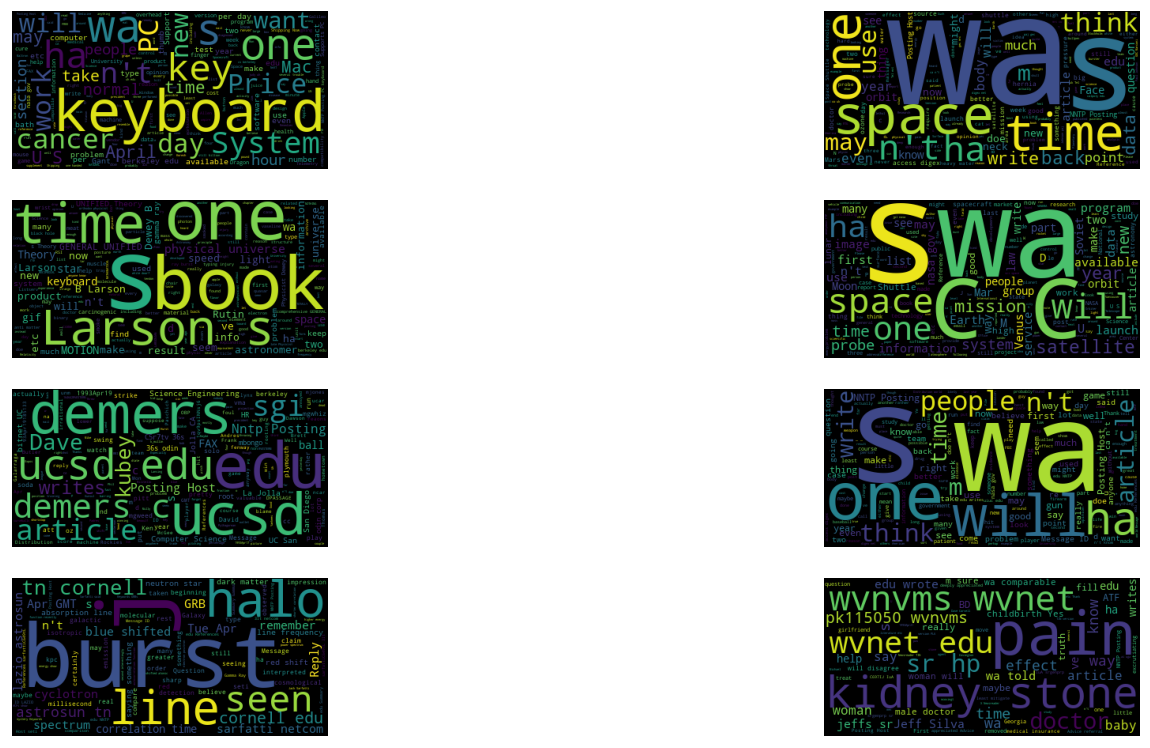

In [81]:
# The best results were obtained using kmeans and 4,8 clusters
# Let's use word clouds to display what each cluster actually talks about

import wordcloud

kmeans = KMeans(n_clusters=8).fit(tfidf_X)
_, axes = plt.subplots(4, 2, figsize=(16, 8))
for ax, cluster_id in zip(np.ravel(axes), range(8)):
    cluster_lemmas = []
    ltk = LemmaTokenizer()
    for doc in ((kmeans.labels_ == cluster_id).nonzero())[0]:
        cluster_lemmas.extend(ltk(corpus[doc]))

    wc = wordcloud.WordCloud().generate(" ".join(cluster_lemmas))
    ax.imshow(wc)
    ax.axis("off")

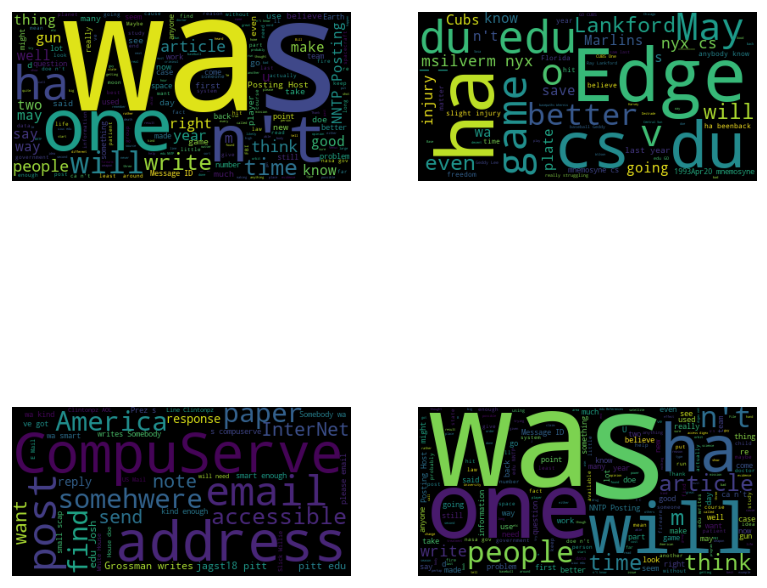

In [82]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters).fit(tfidf_X)
_, axes = plt.subplots(2, 2, figsize=(8, 8))
for ax, cluster_id in zip(np.ravel(axes), range(n_clusters)):
    cluster_lemmas = []
    ltk = LemmaTokenizer()
    for doc in ((kmeans.labels_ == cluster_id).nonzero())[0]:
        cluster_lemmas.extend(ltk(corpus[doc]))

    wc = wordcloud.WordCloud().generate(" ".join(cluster_lemmas))
    ax.imshow(wc)
    ax.axis("off")

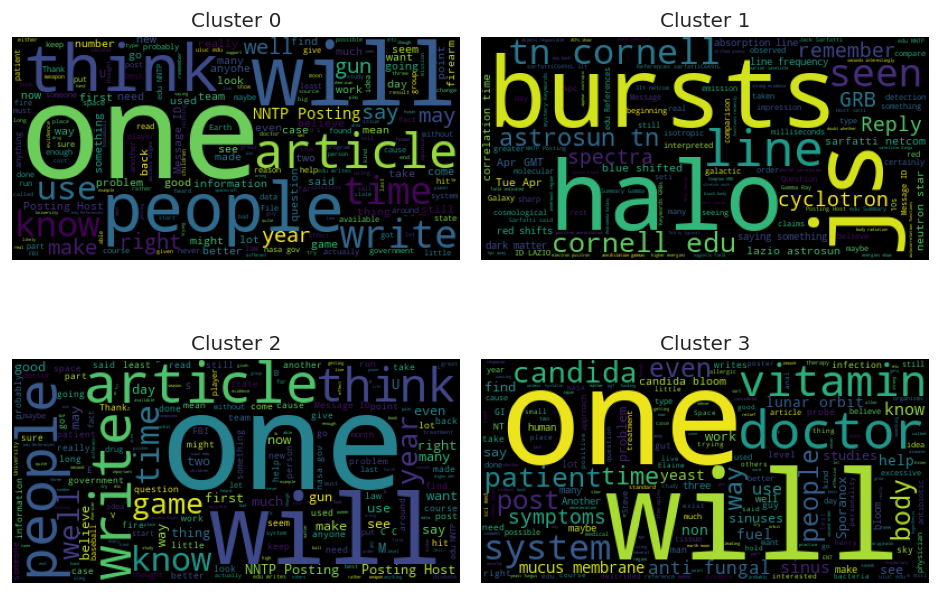

In [86]:
# Let's try printing the actual words rather than their lemmatized versions?

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters).fit(tfidf_X)
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
for ax, cluster_id in zip(np.ravel(axes), range(n_clusters)):
    cluster_lemmas = []
    for doc in ((kmeans.labels_ == cluster_id).nonzero())[0]:
        cluster_lemmas.append(corpus[doc])

    wc = wordcloud.WordCloud().generate(" ".join(cluster_lemmas))
    ax.imshow(wc)
    ax.set_title(f"Cluster {cluster_id
}")
    ax.axis("off")
plt.tight_layout()